In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras import initializers, regularizers, optimizers, layers
from keras.models import load_model
from sklearn import metrics
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
def loadData_Tokenizer(X_train, X_val, X_test, MAX_NB_WORDS=5000,MAX_SEQUENCE_LENGTH=128):
    np.random.seed(7)
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    X_train = text
    sequences = tokenizer.texts_to_sequences(X_val)
    X_val = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    sequences = tokenizer.texts_to_sequences(X_test)
    X_test = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


    embeddings_index = {}
    with open(os.path.join('/content/drive/MyDrive/Classroom', 'glove.6B.100d.txt')) as f:
      for line in f:
          values = line.split()
          word = values[0]
          try:
              coefs = np.asarray(values[1:], dtype='float32')
          except:
             pass
          embeddings_index[word] = coefs
      f.close()
    return (X_train, X_val,X_test, word_index,embeddings_index)

In [ ]:
def Build_Model_RCNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=128, EMBEDDING_DIM=100):

    kernel_size = 4
    filters = 100
    pool_size = 5
    gru_node = 128

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector

 
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False))
    model.add(Conv1D(filters=100, kernel_size=5,padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True,name='lstm_layer',dropout=0.3,recurrent_dropout=0.5)))
    #model.add(Bidirectional(LSTM(128, return_sequences=True,name='lstm_layer',dropout=0.4,recurrent_dropout=0.5)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=512, activation="relu",
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(3, activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False,
    name="Adam")
    model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])

    return model

In [ ]:
def get_data_train():
  df = pd.read_csv('/content/Train_data_intent1.csv')
  df.head()
  X=df['body']
  Y = df['intent_1'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  Y = to_categorical(Y_nids, num_classes=3)
  return X, Y

In [ ]:
def get_data_val():
  df = pd.read_csv('/content/Valid_data_intent1.csv')
  df.head()
  X_v = df['body']
  Y = df['intent_1'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  y_v = to_categorical(Y_nids, num_classes=3)
  return X_v, y_v

In [ ]:
def get_data_test():
  df = pd.read_csv('/content/Test_data_intent1.csv')
  df.head()
  X_v = df['body']
  Y = df['intent_1'].astype("category")
  cat_types= Y.cat.categories
  Y_nids = Y.cat.codes
  y_v = to_categorical(Y_nids, num_classes=3)
  return X_v, y_v


In [ ]:
#X_train, X_test1, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
X_train,y_train= get_data_train()
X_test,y_test= get_data_test()
X_val,y_val= get_data_val()

XTRAIN,XVAL,XTEST, word_index, embeddings_index = loadData_Tokenizer(X_train,X_val, X_test)

In [ ]:
nclasses=3

model_RCNNi1 = Build_Model_RCNN_Text(word_index,embeddings_index, nclasses)


model_RCNNi1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 100)          73500     
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 100)          50100     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 64, 100)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 256)          234496    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                      

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath= '/content/drive/MyDrive/Classroom', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model_RCNNi1.fit(XTRAIN, y_train,
                              validation_data=(XVAL,y_val),
                              epochs=30,
                              batch_size=12,
                              verbose=2, callbacks=[checkpointer])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.86771, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 48s - loss: 0.9832 - accuracy: 0.5941 - val_loss: 0.8677 - val_accuracy: 0.6200 - 48s/epoch - 1s/step
Epoch 2/30

Epoch 00002: val_loss improved from 0.86771 to 0.81637, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 47s - loss: 0.8266 - accuracy: 0.6464 - val_loss: 0.8164 - val_accuracy: 0.6000 - 47s/epoch - 1s/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.81637 to 0.76933, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 60s - loss: 0.7790 - accuracy: 0.6841 - val_loss: 0.7693 - val_accuracy: 0.6200 - 60s/epoch - 2s/step
Epoch 4/30

Epoch 00004: val_loss improved from 0.76933 to 0.70725, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 50s - loss: 0.7120 - accuracy: 0.7029 - val_loss: 0.7072 - val_accuracy: 0.6600 - 50s/epoch - 1s/step
Epoch 5/30

Epoch 00005: val_loss improved from 0.70725 to 0.69371, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 59s - loss: 0.7001 - accuracy: 0.7301 - val_loss: 0.6937 - val_accuracy: 0.6600 - 59s/epoch - 1s/step
Epoch 6/30

Epoch 00006: val_loss improved from 0.69371 to 0.65161, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 58s - loss: 0.6017 - accuracy: 0.7657 - val_loss: 0.6516 - val_accuracy: 0.7200 - 58s/epoch - 1s/step
Epoch 7/30

Epoch 00007: val_loss improved from 0.65161 to 0.64228, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 41s - loss: 0.5712 - accuracy: 0.7782 - val_loss: 0.6423 - val_accuracy: 0.7600 - 41s/epoch - 1s/step
Epoch 8/30

Epoch 00008: val_loss improved from 0.64228 to 0.56454, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 43s - loss: 0.4969 - accuracy: 0.8285 - val_loss: 0.5645 - val_accuracy: 0.8200 - 43s/epoch - 1s/step
Epoch 9/30

Epoch 00009: val_loss did not improve from 0.56454
40/40 - 29s - loss: 0.4435 - accuracy: 0.8556 - val_loss: 0.7088 - val_accuracy: 0.6600 - 29s/epoch - 736ms/step
Epoch 10/30

Epoch 00010: val_loss did not improve from 0.56454
40/40 - 29s - loss: 0.4308 - accuracy: 0.8556 - val_loss: 0.6046 - val_accuracy: 0.7600 - 29s/epoch - 725ms/step
Epoch 11/30

Epoch 00011: val_loss improved from 0.56454 to 0.49273, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 41s - loss: 0.3326 - accuracy: 0.9100 - val_loss: 0.4927 - val_accuracy: 0.8400 - 41s/epoch - 1s/step
Epoch 12/30

Epoch 00012: val_loss did not improve from 0.49273
40/40 - 29s - loss: 0.3416 - accuracy: 0.8975 - val_loss: 0.6681 - val_accuracy: 0.6800 - 29s/epoch - 715ms/step
Epoch 13/30

Epoch 00013: val_loss improved from 0.49273 to 0.47994, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 41s - loss: 0.2824 - accuracy: 0.9226 - val_loss: 0.4799 - val_accuracy: 0.8600 - 41s/epoch - 1s/step
Epoch 14/30

Epoch 00014: val_loss improved from 0.47994 to 0.42534, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 42s - loss: 0.2440 - accuracy: 0.9456 - val_loss: 0.4253 - val_accuracy: 0.8800 - 42s/epoch - 1s/step
Epoch 15/30

Epoch 00015: val_loss improved from 0.42534 to 0.40061, saving model to /content/drive/MyDrive/Classroom
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/assets


40/40 - 41s - loss: 0.2135 - accuracy: 0.9498 - val_loss: 0.4006 - val_accuracy: 0.9000 - 41s/epoch - 1s/step
Epoch 16/30

Epoch 00016: val_loss did not improve from 0.40061
40/40 - 29s - loss: 0.1963 - accuracy: 0.9623 - val_loss: 0.4847 - val_accuracy: 0.8600 - 29s/epoch - 729ms/step
Epoch 17/30

Epoch 00017: val_loss did not improve from 0.40061
40/40 - 28s - loss: 0.2010 - accuracy: 0.9540 - val_loss: 0.5270 - val_accuracy: 0.9000 - 28s/epoch - 709ms/step
Epoch 18/30

Epoch 00018: val_loss did not improve from 0.40061
40/40 - 29s - loss: 0.1865 - accuracy: 0.9582 - val_loss: 0.5183 - val_accuracy: 0.8200 - 29s/epoch - 725ms/step
Epoch 19/30

Epoch 00019: val_loss did not improve from 0.40061
40/40 - 29s - loss: 0.1473 - accuracy: 0.9791 - val_loss: 0.4606 - val_accuracy: 0.8800 - 29s/epoch - 716ms/step
Epoch 20/30

Epoch 00020: val_loss did not improve from 0.40061
40/40 - 29s - loss: 0.1255 - accuracy: 0.9854 - val_loss: 0.5001 - val_accuracy: 0.8600 - 29s/epoch - 731ms/step
Epoch

In [ ]:
# evaluate the test accuracy , call evaluate method and give the data 
_, train_acc = model_RCNNi1.evaluate(XTRAIN, y_train)
_, test_acc = model_RCNNi1.evaluate(XTEST, y_test)

print("train acc", train_acc)
print("test acc", test_acc)

3/3 [==============================] - 0s 53ms/step - loss: 0.7965 - accuracy: 0.8026
train acc 0.9979079365730286
test acc 0.8026315569877625


In [ ]:
# take the class that is most likely to be the correct one based on model's opinion
y_pred = model_RCNNi1.predict(XTEST)

In [ ]:
predicted = np.argmax(y_pred, axis=1)

In [ ]:
# model metrics to be defined 
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
 target_name = ['Asking for information', 'NAN', 'Providing information']

In [ ]:
# print classification report 
print(metrics.classification_report(np.argmax(y_test, axis=1), predicted , target_names=target_name))

                        precision    recall  f1-score   support

Asking for information       0.70      0.67      0.68        21
                   NAN       0.75      0.67      0.71         9
 Providing information       0.85      0.89      0.87        46

              accuracy                           0.80        76
             macro avg       0.77      0.74      0.75        76
          weighted avg       0.80      0.80      0.80        76



In [ ]:
# create a confusion matrix and chart it
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted )
df_cm = pd.DataFrame(cm, index=target_name, columns=target_name)

In [ ]:
# data visualization at the time of data import and model metrics
import seaborn as sns
# we can set the parameters for each plot 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


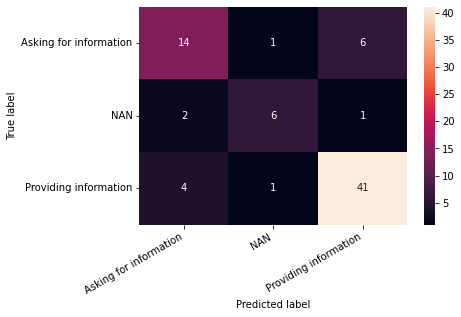

In [ ]:
# using a heatmap from seaborn to visualize the confusion matric
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');